In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import pandas as pd

from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers.legacy import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.13.0


In [32]:
#Load dataset

data_path = "dataset/"
emotions = os.listdir(data_path)

# Check for '.DS_Store' and delete it
if '.DS_Store' in emotions:
    os.remove(os.path.join(data_path, '.DS_Store'))
    emotions.remove('.DS_Store')

print(emotions)

['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']


dataset/happy
dataset/sad
dataset/fear
dataset/surprise
dataset/neutral
dataset/angry
dataset/disgust


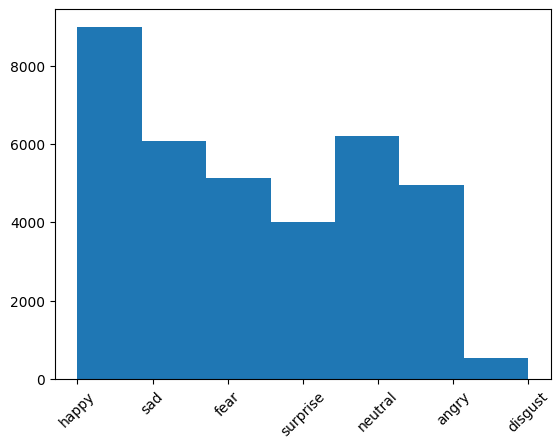

In [33]:
img_size = 48 #By default, the images in FER2013 dataset is in 48x48

data = []
labels = []

# Looping through subfolders in the data path
for emotion in emotions:
    emotion_folder = os.path.join(data_path, emotion)
    print(emotion_folder)
    if not os.path.isdir(emotion_folder):
        continue
    for img in os.listdir(emotion_folder):
        img_path = os.path.join(emotion_folder, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            data.append(img)
            labels.append(emotions.index(emotion))

# Convert image data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Plot the distribution of the labels, bar graph
plt.hist(labels, bins=len(emotions))
plt.xticks(range(len(emotions)), emotions, rotation=45)
plt.show()

In [34]:
from sklearn.utils.class_weight import compute_sample_weight

# Load the images and their labels
image_dir = "./dataset/"
labels = []
images = []
for folder in os.listdir(image_dir):
    for file in os.listdir(os.path.join(image_dir, folder)):
        if file.endswith(".jpg"):
            images.append(img_to_array(load_img(os.path.join(image_dir, folder, file), color_mode="grayscale")))
            labels.append(folder)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the images
images = images / 255.0

# One-hot encode the labels
label_dict = {label: i for i, label in enumerate(np.unique(labels))}
labels = to_categorical(np.vectorize(label_dict.get)(labels))

# Convert one-hot encoded labels back to their original form
original_labels = np.argmax(labels, axis=1)

# Define the mapping
emotion_to_vac = {
    'Happy': [0.8, 0.8],
    'Angry': [-0.8, 0.8],
    'Surprise': [0.8, 0.8],
    'Fear': [-0.8, 0.8],
    'Sad': [-0.8, -0.8],
    'Disgust': [-0.8, 0.8],
    'Neutral': [0.0, 0.0]
}

# Define class_names, to be used for CM
class_names = list(emotion_to_vac.keys())


# Reverse the label_dict
reverse_label_dict = {v: k for k, v in label_dict.items()}

# Convert integer labels back to emotion names and capitalize them
emotion_labels = [reverse_label_dict[label].capitalize() for label in original_labels]

# Transform your labels into Valence-Arousal coordinates
vac_labels = np.array([emotion_to_vac[emotion] for emotion in emotion_labels])

# Transform your labels into Valence-Arousal coordinates
vac_labels = np.array([emotion_to_vac[emotion] for emotion in emotion_labels])

# Compute class weights
class_weights = compute_sample_weight(class_weight='balanced', y=original_labels)
n_samples = len(original_labels)
n_classes = len(np.unique(original_labels))
counts = np.bincount(original_labels)
class_weights = n_samples / (n_classes * counts)

# Split the data into training and testing sets
train_images, test_images, train_vac_labels, test_vac_labels = train_test_split(images, vac_labels, test_size=0.3, stratify=original_labels, random_state=42)


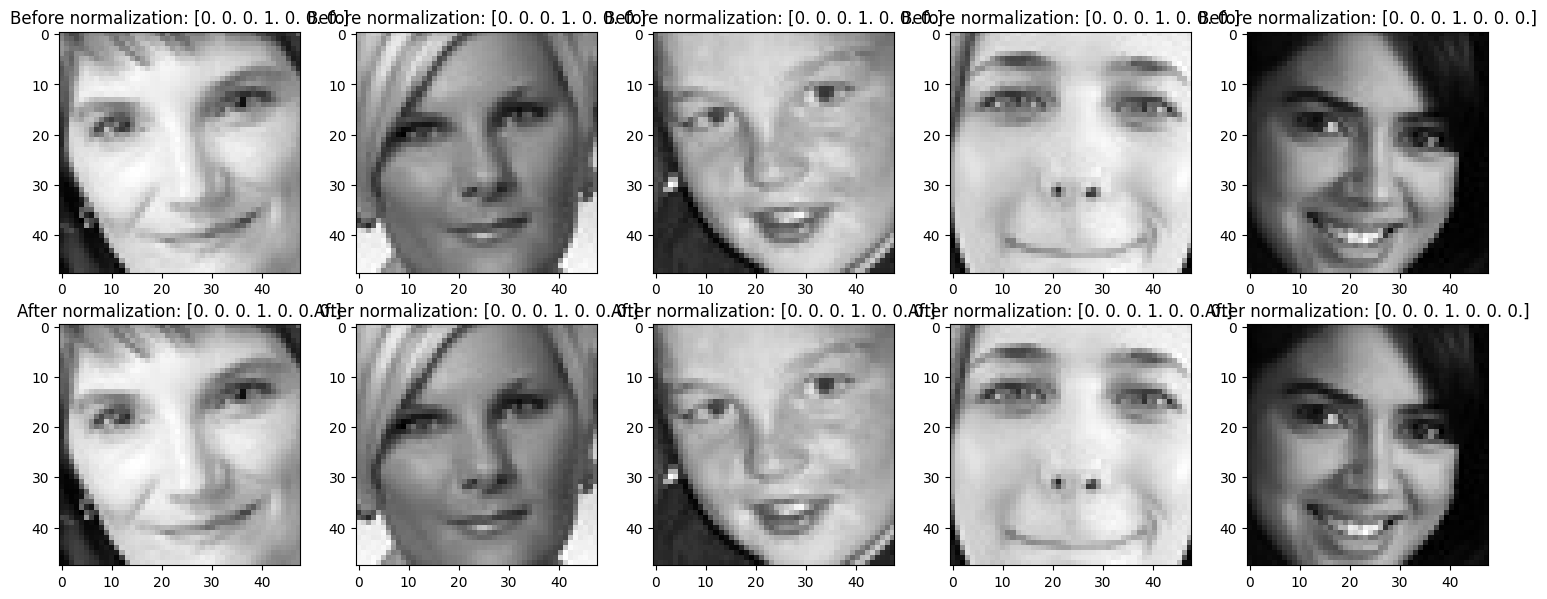

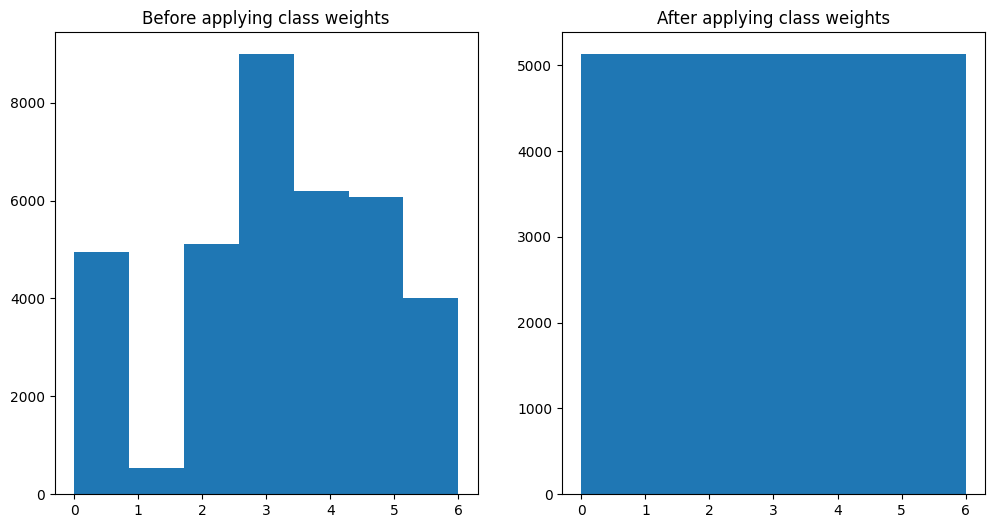

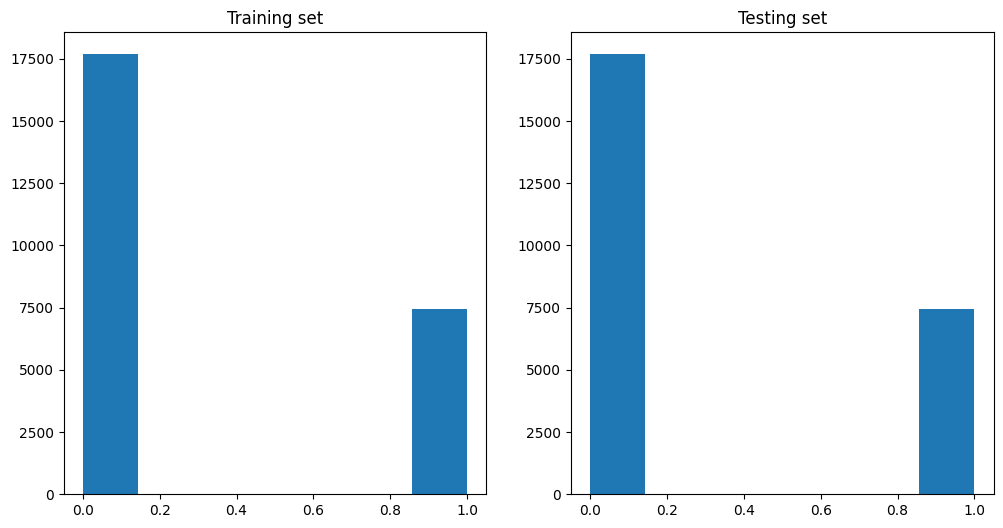

In [35]:
import matplotlib.pyplot as plt

# Visualize some images before and after normalization
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Before normalization
    axs[0, i].imshow(images[i] * 255, cmap='gray')
    axs[0, i].set_title(f'Before normalization: {labels[i]}')
    # After normalization
    axs[1, i].imshow(images[i], cmap='gray')
    axs[1, i].set_title(f'After normalization: {labels[i]}')
plt.tight_layout()
plt.show()

# Create an array of class weights for each sample
sample_weights = class_weights[original_labels]

# Plot the distribution of your labels before and after applying class weights
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(original_labels, bins=n_classes)
axs[0].set_title('Before applying class weights')
axs[1].hist(original_labels, weights=sample_weights, bins=n_classes)
axs[1].set_title('After applying class weights')
plt.show()

# Visualize the distribution of your data after splitting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(np.argmax(train_vac_labels, axis=1), bins=n_classes)
axs[0].set_title('Training set')
axs[1].hist(np.argmax(train_vac_labels, axis=1), bins=n_classes)
axs[1].set_title('Testing set')
plt.show()

In [43]:
from keras.regularizers import l2

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1), kernel_regularizer=l2(0.01)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(2)  # 2 outputs for the valence and arousal
])

model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])

In [51]:
import io
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image

# Define the TensorBoard and Scatter Plot callbacks.
log_dir = "logs/image/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')

def log_scatter_plot(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred = model.predict(test_images)

    # Plot actual vs predicted values.
    figure, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].scatter(test_vac_labels[:, 0], test_pred[:, 0])
    axes[0].set_xlabel('Actual Valence')
    axes[0].set_ylabel('Predicted Valence')
    axes[0].set_title('Valence')
    axes[1].scatter(test_vac_labels[:, 1], test_pred[:, 1])
    axes[1].set_xlabel('Actual Arousal')
    axes[1].set_ylabel('Predicted Arousal')
    axes[1].set_title('Arousal')

    # Convert the plot to a PNG image and return it.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Log the scatter plot as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Valence and Arousal Scatter Plots", image, step=epoch)

Epoch 1/10
337/337 [==============================] - 2s 5ms/step


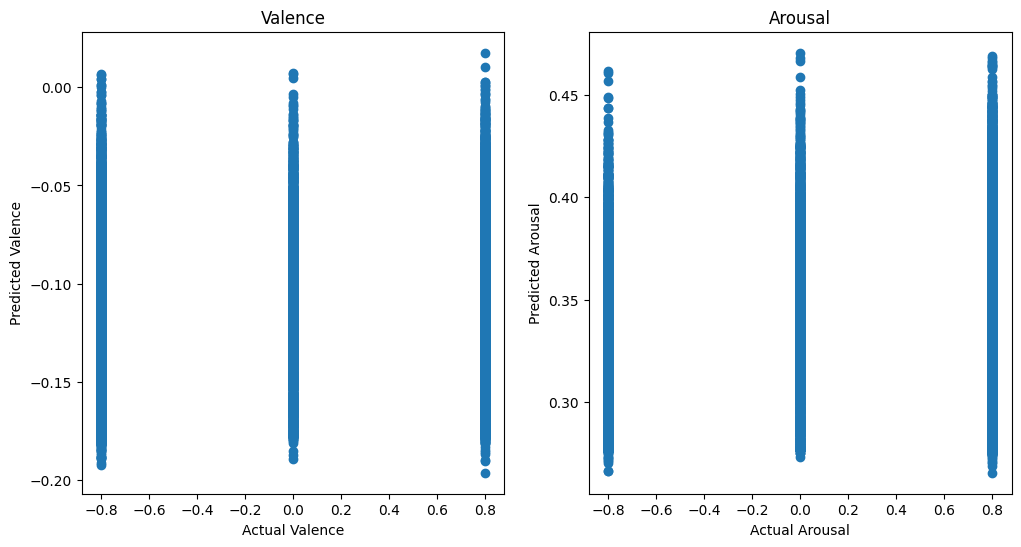

785/785 [==============================] - 25s 32ms/step - loss: 0.4461 - mean_squared_error: 0.4427 - val_loss: 0.4468 - val_mean_squared_error: 0.4437
Epoch 2/10
337/337 [==============================] - 1s 4ms/step


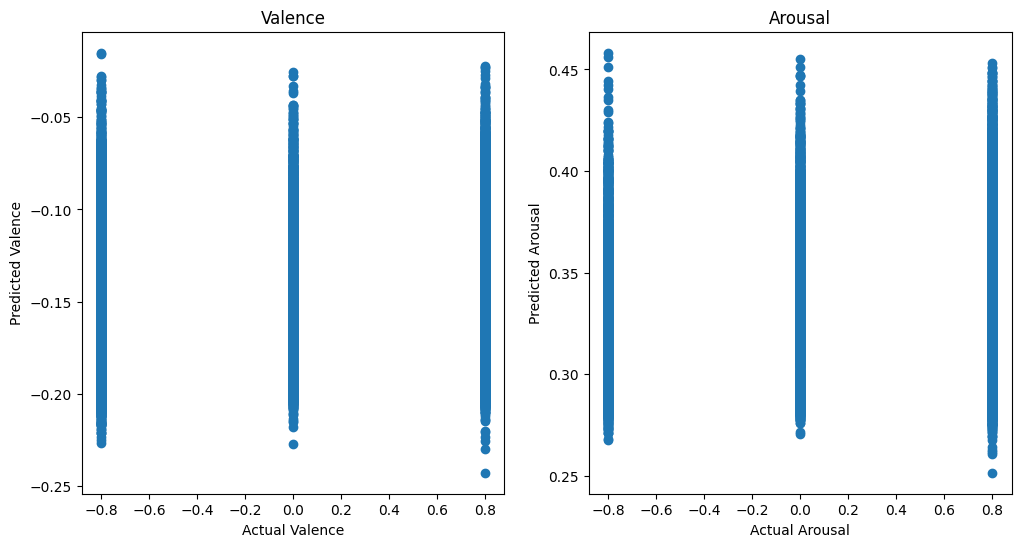

785/785 [==============================] - 25s 31ms/step - loss: 0.4459 - mean_squared_error: 0.4426 - val_loss: 0.4485 - val_mean_squared_error: 0.4452
Epoch 3/10
337/337 [==============================] - 1s 4ms/step


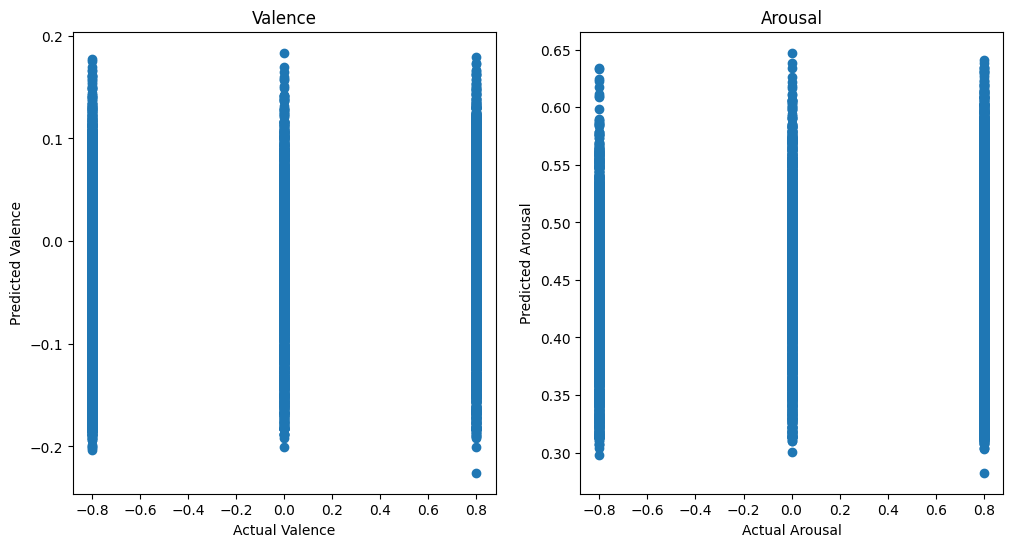

785/785 [==============================] - 25s 32ms/step - loss: 0.4465 - mean_squared_error: 0.4431 - val_loss: 0.4483 - val_mean_squared_error: 0.4446
Epoch 4/10
337/337 [==============================] - 1s 4ms/step


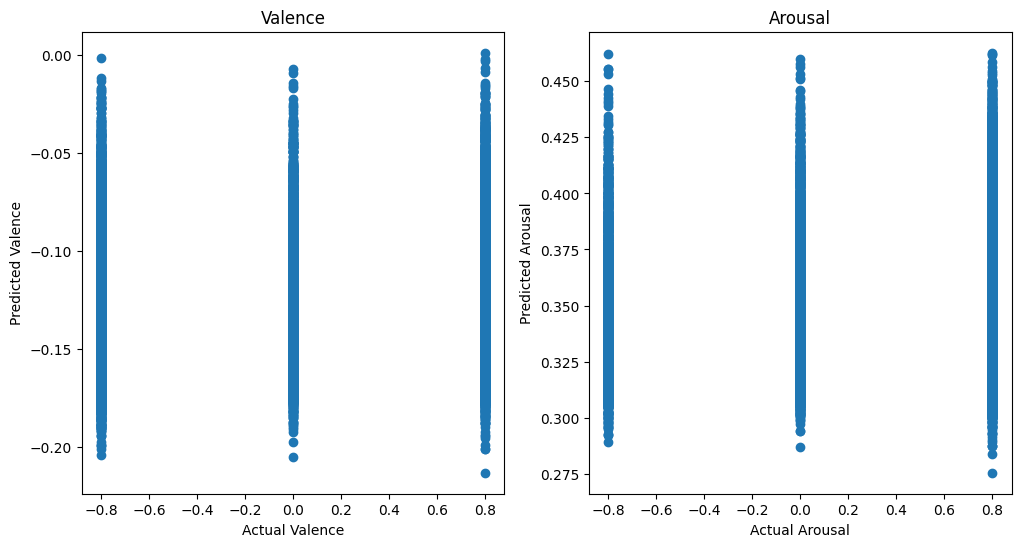

785/785 [==============================] - 25s 32ms/step - loss: 0.4459 - mean_squared_error: 0.4423 - val_loss: 0.4481 - val_mean_squared_error: 0.4446
Epoch 5/10
337/337 [==============================] - 2s 5ms/step


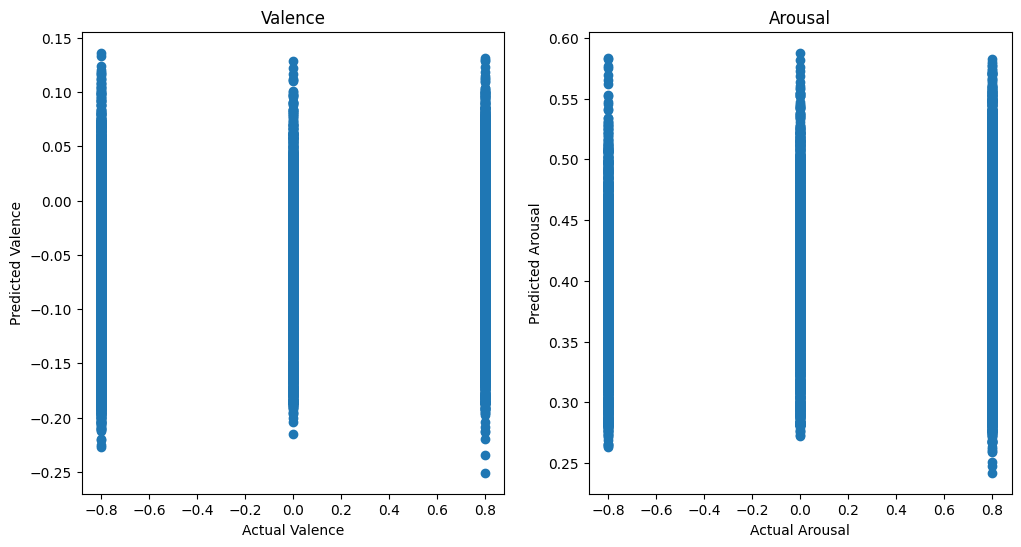

785/785 [==============================] - 25s 32ms/step - loss: 0.4458 - mean_squared_error: 0.4422 - val_loss: 0.4442 - val_mean_squared_error: 0.4403
Epoch 6/10
337/337 [==============================] - 1s 4ms/step


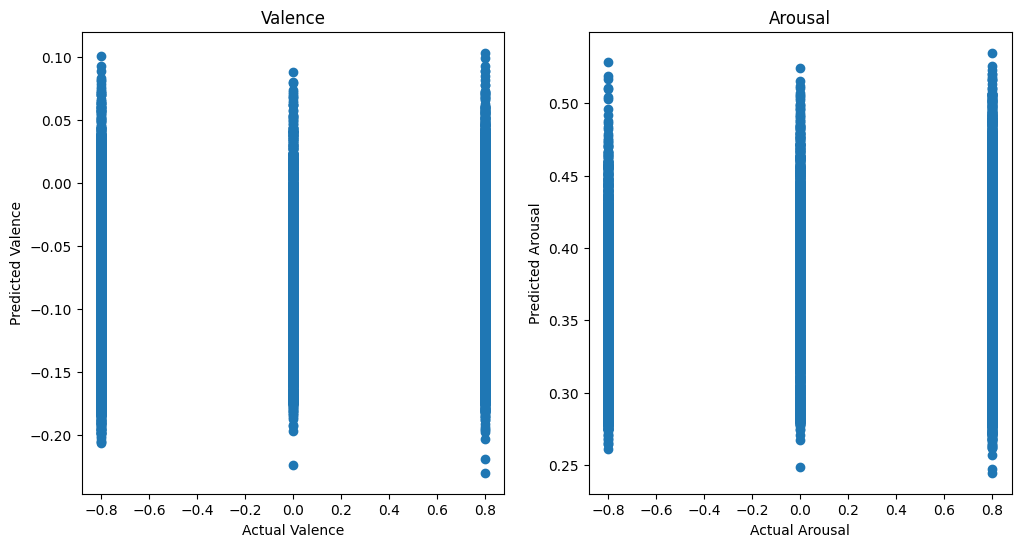

785/785 [==============================] - 25s 32ms/step - loss: 0.4467 - mean_squared_error: 0.4429 - val_loss: 0.4446 - val_mean_squared_error: 0.4410
Epoch 7/10
337/337 [==============================] - 1s 2ms/steposs: 0


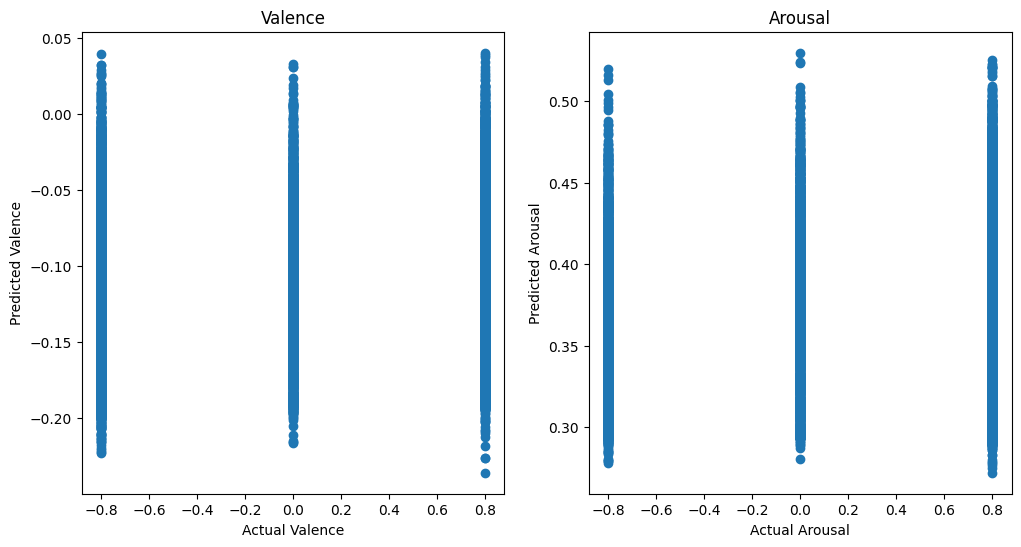

785/785 [==============================] - 24s 31ms/step - loss: 0.4458 - mean_squared_error: 0.4422 - val_loss: 0.4449 - val_mean_squared_error: 0.4412
Epoch 8/10
337/337 [==============================] - 2s 5ms/step


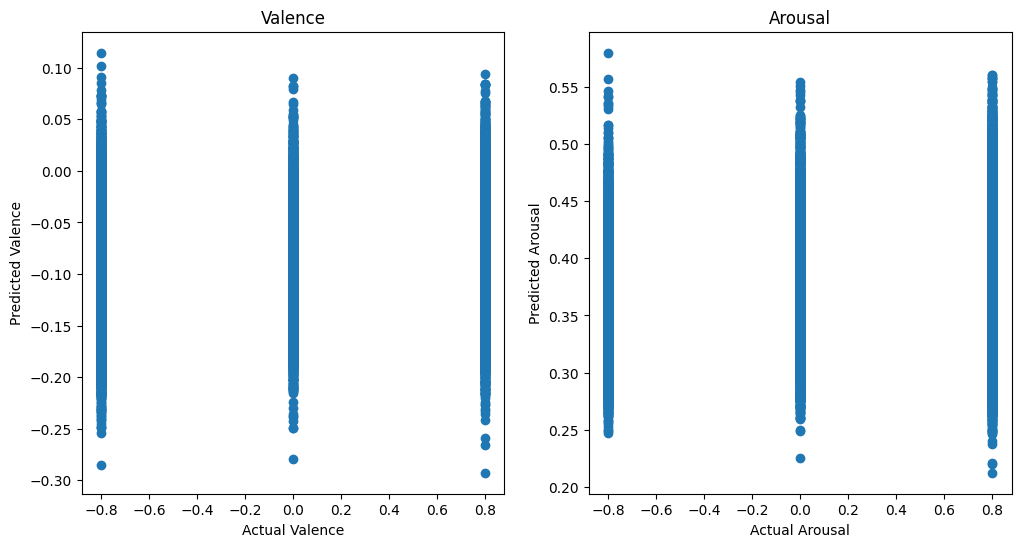

785/785 [==============================] - 26s 33ms/step - loss: 0.4455 - mean_squared_error: 0.4419 - val_loss: 0.4440 - val_mean_squared_error: 0.4400
Epoch 9/10
337/337 [==============================] - 2s 5ms/step


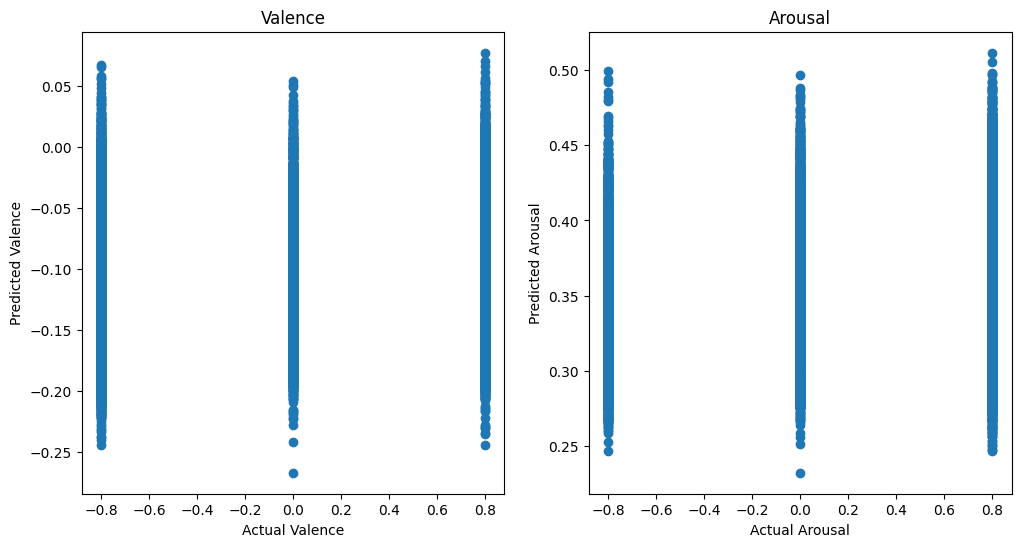

785/785 [==============================] - 26s 33ms/step - loss: 0.4454 - mean_squared_error: 0.4417 - val_loss: 0.4446 - val_mean_squared_error: 0.4408
Epoch 10/10
337/337 [==============================] - 1s 4ms/step


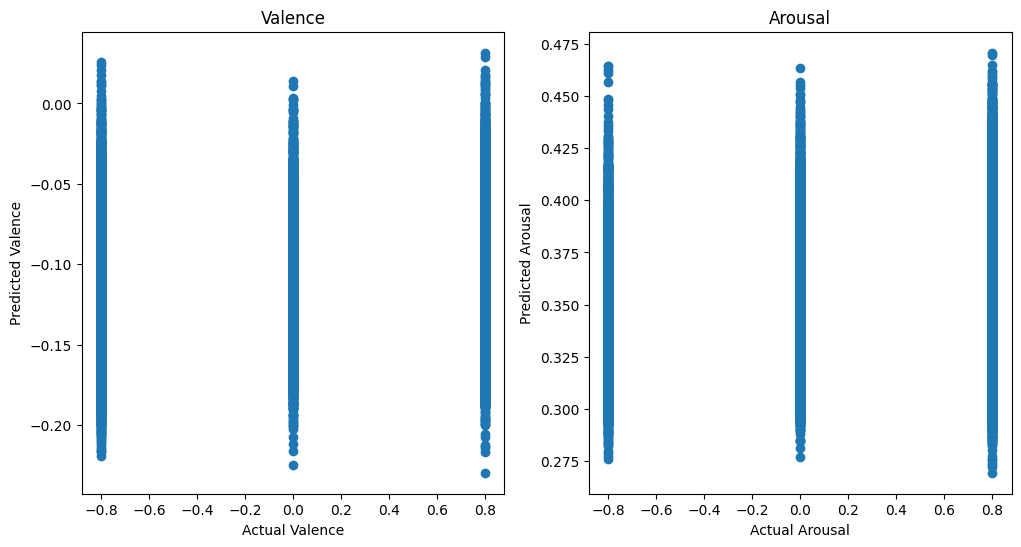

785/785 [==============================] - 25s 32ms/step - loss: 0.4460 - mean_squared_error: 0.4422 - val_loss: 0.4460 - val_mean_squared_error: 0.4424


In [54]:
from keras.callbacks import Callback, TensorBoard
import matplotlib.pyplot as plt


class ScatterPlotCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Use the model to predict the values from the validation dataset.
        test_pred = self.model.predict(test_images)

        # Plot actual vs predicted values.
        figure, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].scatter(test_vac_labels[:, 0], test_pred[:, 0])
        axes[0].set_xlabel('Actual Valence')
        axes[0].set_ylabel('Predicted Valence')
        axes[0].set_title('Valence')
        axes[1].scatter(test_vac_labels[:, 1], test_pred[:, 1])
        axes[1].set_xlabel('Actual Arousal')
        axes[1].set_ylabel('Predicted Arousal')
        axes[1].set_title('Arousal')
        plt.show()

scatter_plot_callback = ScatterPlotCallback()

# Define the TensorBoard callback.
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Now you can use the tensorboard_callback in your model.fit call.
model.fit(train_images,
          train_vac_labels,
          batch_size=32,
          epochs=10,
          verbose=1,
          validation_data=(test_images, test_vac_labels),
          callbacks=[tensorboard_callback, scatter_plot_callback])

In [49]:
import pickle

# Save the model architecture to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save model's weights
model.save_weights("model_weights.h5")

# Save entire model
model.save("model.h5")

# Save the mapping
with open('emotion_to_vac.pkl', 'wb') as f:
    pickle.dump(emotion_to_vac, f)


337/337 [==============================] - 2s 5ms/step


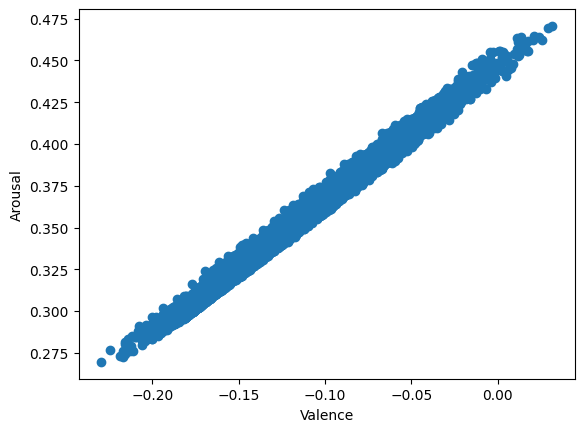

In [55]:
import matplotlib.pyplot as plt

# Predict the valence-arousal coordinates for the test images
predictions = model.predict(test_images)

# Plot the predicted valence-arousal coordinates
plt.scatter(predictions[:, 0], predictions[:, 1])
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.show()